# Predicting English Premier League Match Outcomes Using ML Models

In this notebook, the code of the project is being presented in small readable sections. For more information about the project please refer to the Written Report.

***

## Imports

Firstly, we import all the necessary libraries.

In [19]:
from pathlib import Path
import pandas as pd 
import numpy as np
import torch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight

***

## Dataset 

Let's take a look in the dataset

In [20]:
# The results.xlsx file should be placed inside the Dataset folder of the directory.
root_folder = Path(__file__).parent if "__file__" in globals() else Path.cwd()
root_folder /= 'Dataset'
root_folder /= 'results.xlsx'
root_folder

# In order to read the file, openpyxl is also needed
df = pd.read_excel(root_folder)
df.head()

,Season,DateTime,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
0,1993-94,1993-08-14T00:00:00Z,Arsenal,Coventry,0,3,A,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-94,1993-08-14T00:00:00Z,Aston Villa,QPR,4,1,H,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1993-94,1993-08-14T00:00:00Z,Chelsea,Blackburn,1,2,A,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1993-94,1993-08-14T00:00:00Z,Liverpool,Sheffield Weds,2,0,H,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1993-94,1993-08-14T00:00:00Z,Man City,Leeds,1,1,D,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Using the *unique* function we can check how many seasons are in the dataset.

In [21]:
seasons = df['Season'].unique()
seasons

array(['1993-94', '1994-95', '1995-96', '1996-97', '1997-98', '1998-99',
       '1999-00', '2000-01', '2001-02', '2002-03', '2003-04', '2004-05',
       '2005-06', '2006-07', '2007-08', '2008-09', '2009-10', '2010-11',
       '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17',
       '2017-18', '2018-19', '2019-20', '2020-21', '2021-22'],
      dtype=object)

Since the scores of each Matchweek are available, we can easily create a league table for each season. While this is not important for the match predictions, it is usually a good practice to visualize the data.

In [22]:
# Create league table for each season
pd.set_option('future.no_silent_downcasting', True)
league_tables = {}
for season in seasons:
    season_data = df[df['Season'] == season]
    teams = pd.unique(season_data[['HomeTeam', 'AwayTeam']].values.ravel('K'))
    league_table = pd.DataFrame(index=teams, columns=['Played', 'Won', 'Drawn', 'Lost', 'Goals For', 'Goals Against', 'Goal Difference', 'Points'])
    league_table.fillna(0, inplace=True)
    
    for _, match in season_data.iterrows():
        home_team = match['HomeTeam']
        away_team = match['AwayTeam']
        home_goals = match['FTHG']
        away_goals = match['FTAG']
        
        league_table.at[home_team, 'Played'] += 1
        league_table.at[away_team, 'Played'] += 1
        league_table.at[home_team, 'Goals For'] += home_goals
        league_table.at[home_team, 'Goals Against'] += away_goals
        league_table.at[away_team, 'Goals For'] += away_goals
        league_table.at[away_team, 'Goals Against'] += home_goals
        
        if home_goals > away_goals:
            league_table.at[home_team, 'Won'] += 1
            league_table.at[away_team, 'Lost'] += 1
            league_table.at[home_team, 'Points'] += 3
        elif home_goals < away_goals:
            league_table.at[away_team, 'Won'] += 1
            league_table.at[home_team, 'Lost'] += 1
            league_table.at[away_team, 'Points'] += 3
        else:
            league_table.at[home_team, 'Drawn'] += 1
            league_table.at[away_team, 'Drawn'] += 1
            league_table.at[home_team, 'Points'] += 1
            league_table.at[away_team, 'Points'] += 1
    
    league_table['Goal Difference'] = league_table['Goals For'] - league_table['Goals Against']
    league_table.sort_values(by=['Points', 'Goal Difference', 'Goals For'], ascending=False, inplace=True)
    league_tables[season] = league_table

Let's check the miracle season '2015-2016' when Leicester City became the Premier League Champions!

In [23]:
league_tables['2015-16']

,Played,Won,Drawn,Lost,Goals For,Goals Against,Goal Difference,Points
Leicester,38,23,12,3,68,36,32,81
Arsenal,38,20,11,7,65,36,29,71
Tottenham,38,19,13,6,69,35,34,70
Man City,38,19,9,10,71,41,30,66
Man United,38,19,9,10,49,35,14,66
Southampton,38,18,9,11,59,41,18,63
West Ham,38,16,14,8,65,51,14,62
Liverpool,38,16,12,10,63,50,13,60
Stoke,38,14,9,15,41,55,-14,51
Chelsea,38,12,14,12,59,53,6,50


### Cleaning the data

After a quick inspection, one can observe that during the time the dataset was created the last season (2021-22) was still incomplete. Furthermore, the first two seasons don't have complete data for Half Time Goals (HTHG, HTAG). 

In [24]:
for season in seasons:
    if len(league_tables[season]['Played'].unique()) != 1:
        print(f"Season {season} is incomplete.")
    missing_ht_data = (df[df['Season'] == season][['HTHG', 'HTAG']].isna().sum())
    if missing_ht_data['HTHG'] != 0 or missing_ht_data['HTAG'] != 0:
        print(f"Season {season} missing HTHG: {missing_ht_data['HTHG']}, missing HTAG: {missing_ht_data['HTAG']}")

Season 1993-94 missing HTHG: 462, missing HTAG: 462
Season 1994-95 missing HTHG: 462, missing HTAG: 462
Season 2021-22 is incomplete.


We delete the corresponding seasons from the dataset.

In [25]:
df = df[df['Season'] != '2021-22']
df = df[df['Season'] != '1993-94']
df = df[df['Season'] != '1994-95']

We then reset the index.

In [26]:
df.reset_index(drop= True, inplace= True)
df.head()

,Season,DateTime,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
0,1995-96,1995-08-19T00:00:00Z,Aston Villa,Man United,3,1,H,3.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1995-96,1995-08-19T00:00:00Z,Blackburn,QPR,1,0,H,1.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1995-96,1995-08-19T00:00:00Z,Chelsea,Everton,0,0,D,0.0,0.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1995-96,1995-08-19T00:00:00Z,Liverpool,Sheffield Weds,1,0,H,0.0,0.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1995-96,1995-08-19T00:00:00Z,Man City,Tottenham,1,1,D,0.0,1.0,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Team Encoding

Right now, teams are encoded as string variables, however ML models expect numbers. For this reason, we will transform each team into a unique integer that will correspond the team's strength throughout history. For example Blackpool will be on the lower end, while Chelsea will be near the top.

Since Full Time Result is represented as a string, it is transformed to an integer as well. 0 for Draw, 1 for Home Win, 2 for Away Win.

Lastly, each season gets each unique code.

In [27]:
# View Unique Home and Away teams
home = df['HomeTeam'].unique()
away = df['AwayTeam'].unique()

len(home), len(away)

(47, 47)

In [28]:
# For each game each team gets +3, +1 or 0 depending on the result
teams = df['HomeTeam'].unique()
tally = {team: 0 for team in teams}
for _, match in df.iterrows():
    if match['FTR'] == 'H':
        tally[match['HomeTeam']] += 3
    elif match['FTR'] == 'A':
        tally[match['AwayTeam']] += 3
    else:
        tally[match['AwayTeam']] += 1
        tally[match['HomeTeam']] += 1

In [29]:
# Sorting and printing the dictionary
keys = list(tally.keys())
values = list(tally.values())
sorted_value_index = np.argsort(values)
sorted_dict = {keys[i]: values[i] for i in sorted_value_index}

print(sorted_dict)

{'Barnsley': 35, 'Blackpool': 39, 'Huddersfield': 53, 'Bradford': 62, 'Cardiff': 64, 'Ipswich': 102, 'Sheffield United': 115, 'Reading': 119, "Nott'm Forest": 122, 'QPR': 125, 'Brighton': 158, 'Hull': 171, 'Bournemouth': 211, 'Norwich': 212, 'Wimbledon': 216, 'Sheffield Weds': 218, 'Coventry': 251, 'Watford': 262, 'Derby': 274, 'Burnley': 290, 'Wolves': 297, 'Birmingham': 301, 'Portsmouth': 302, 'Swansea': 312, 'Wigan': 331, 'Charlton': 361, 'Crystal Palace': 422, 'Stoke': 457, 'West Brom': 490, 'Leeds': 557, 'Bolton': 575, 'Sunderland': 618, 'Middlesbrough': 620, 'Fulham': 640, 'Leicester': 706, 'Blackburn': 726, 'Southampton': 876, 'West Ham': 1100, 'Aston Villa': 1134, 'Newcastle': 1212, 'Man City': 1385, 'Everton': 1388, 'Tottenham': 1550, 'Liverpool': 1824, 'Arsenal': 1894, 'Chelsea': 1903, 'Man United': 2044}


In [30]:
# Given the value in the sorted_dict, assign ranks to each team on the initial dataframe
df['Rank_Home'] = df['HomeTeam'].map(lambda x: list(sorted_dict.keys()).index(x) + 1)
df['Rank_Away'] = df['AwayTeam'].map(lambda x: list(sorted_dict.keys()).index(x) + 1)
# FResult if Home win 1, Draw 0, Away win 2
df['FResult'] = df['FTR'].map(lambda x: 1 if x == 'H' else (2 if x == 'A' else 0))


# Season ID
df['SeasonID'] = df['Season'].astype('category').cat.codes + 1
df.head()

,Season,DateTime,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,HF,AF,HY,AY,HR,AR,Rank_Home,Rank_Away,FResult,SeasonID
0,1995-96,1995-08-19T00:00:00Z,Aston Villa,Man United,3,1,H,3.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,39,47,1,1
1,1995-96,1995-08-19T00:00:00Z,Blackburn,QPR,1,0,H,1.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,36,10,1,1
2,1995-96,1995-08-19T00:00:00Z,Chelsea,Everton,0,0,D,0.0,0.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,46,42,0,1
3,1995-96,1995-08-19T00:00:00Z,Liverpool,Sheffield Weds,1,0,H,0.0,0.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,44,16,1,1
4,1995-96,1995-08-19T00:00:00Z,Man City,Tottenham,1,1,D,0.0,1.0,A,...,NaN,NaN,NaN,NaN,NaN,NaN,41,43,0,1


### Feature Engineering

The information that will be fed through the ML algorithms will contain the Half-Time score, the Season, the Teams' Ranks as well as some previous match form. 

Specifically, the model will know the average goals scored and taken in the previous five games and the total points collected.

Since these are not directly given in the dataset we will have to create such columns.

In [31]:
# Gather the required columns from the initial dataset
fe_df = df[['SeasonID', 'Rank_Home', 'Rank_Away', 'HTHG', 'HTAG', 'FTHG', 'FTAG', 'FResult']].copy()

# MatchID is useful for keeping the games in chronological order
fe_df.loc[:,'MatchID'] = fe_df.index

# Calculate total points in each match
# For home team
fe_df.loc[:,'Points_Home'] = fe_df.apply(lambda r: 3 if r['FTHG'] > r['FTAG'] else (1 if r['FTHG'] == r['FTAG'] else 0), axis=1)
# For away team
fe_df.loc[:, 'Points_Away'] = fe_df.apply(lambda r: 3 if r['FTAG'] > r['FTHG'] else (1 if r['FTHG'] == r['FTAG'] else 0), axis=1)

fe_df.head()

,SeasonID,Rank_Home,Rank_Away,HTHG,HTAG,FTHG,FTAG,FResult,MatchID,Points_Home,Points_Away
0,1,39,47,3.0,0.0,3,1,1,0,3,0
1,1,36,10,1.0,0.0,1,0,1,1,3,0
2,1,46,42,0.0,0.0,0,0,0,2,1,1
3,1,44,16,0.0,0.0,1,0,1,3,3,0
4,1,41,43,0.0,1.0,1,1,0,4,1,1


In [32]:
# First, gather information about each game's home team
home = fe_df[['MatchID', 'Rank_Home', 'FTHG', 'FTAG', 'Points_Home']].copy()
home.columns = ['MatchID', 'Team', 'Goals_For', 'Goals_Against', 'Points_Home']
home['Venue'] = 'home'

# And away team
away = fe_df[['MatchID', 'Rank_Away', 'FTAG', 'FTHG', 'Points_Away']].copy()
away.columns = ['MatchID', 'Team', 'Goals_For', 'Goals_Against', 'Points_Away']
away['Venue'] = 'away'


# Concatenate them into a long dataframe, containing information about each team's performance in every game
long_df = pd.concat([home, away], ignore_index=True)
long_df = long_df.sort_values(['Team', 'MatchID']).reset_index(drop=True)

# Since each team will get points on the home or away column, the other one will be filled with NaN. To prevent errors, we set these to zero.
long_df[['Points_Away', 'Points_Home']] = long_df[['Points_Away', 'Points_Home']].fillna(0.0)
long_df['Points'] = long_df['Points_Away'] + long_df['Points_Home']

# We drop every column that is redundant.
long_df = long_df.drop(['Points_Home', 'Points_Away'], axis = 1)
long_df.head(10)

,MatchID,Team,Goals_For,Goals_Against,Venue,Points
0,760,1,1,2,home,0.0
1,771,1,1,0,away,3.0
2,786,1,0,6,home,0.0
3,789,1,2,1,home,3.0
4,800,1,0,1,away,0.0
5,806,1,0,3,home,0.0
6,817,1,2,4,away,0.0
7,827,1,1,4,away,0.0
8,836,1,0,2,home,0.0
9,845,1,0,5,away,0.0


Now we are able to calculate the rolling mean for each feature.

In [33]:
grouped = long_df.groupby('Team')

N = 5  # window

# Compute rolling averages using shift() to avoid leaking current match
long_df['GF_avg'] = grouped['Goals_For'].transform(lambda x: x.shift().rolling(N, min_periods=1).mean())
long_df['GA_avg'] = grouped['Goals_Against'].transform(lambda x: x.shift().rolling(N, min_periods=1).mean())
long_df['Points_avg'] = grouped['Points'].transform(lambda x: x.shift().rolling(N, min_periods=1).mean())

# See first rows for a specific team to check results
some_team = long_df['Team'].iloc[0]
display(long_df[long_df['Team'] == some_team].head(10))

,MatchID,Team,Goals_For,Goals_Against,Venue,Points,GF_avg,GA_avg,Points_avg
0,760,1,1,2,home,0.0,NaN,NaN,NaN
1,771,1,1,0,away,3.0,1.000000,2.000000,0.0
2,786,1,0,6,home,0.0,1.000000,1.000000,1.5
3,789,1,2,1,home,3.0,0.666667,2.666667,1.0
4,800,1,0,1,away,0.0,1.000000,2.250000,1.5
5,806,1,0,3,home,0.0,0.800000,2.000000,1.2
6,817,1,2,4,away,0.0,0.600000,2.200000,1.2
7,827,1,1,4,away,0.0,0.800000,3.000000,0.6
8,836,1,0,2,home,0.0,1.000000,2.600000,0.6
9,845,1,0,5,away,0.0,0.600000,2.800000,0.0


All that's left is to merge the new dataset back to the original one.

In [34]:
# Home stats: pick rows where Venue == 'home' (there's exactly one per match)
home_stats = long_df[long_df['Venue'] == 'home'][['MatchID', 'GF_avg', 'GA_avg', 'Points_avg']].rename(
    columns={'GF_avg': 'GF_avg_home', 'GA_avg': 'GA_avg_home', 'Points_avg': 'Points_avg_home'}
)

# Away stats: pick rows where Venue == 'away'
away_stats = long_df[long_df['Venue'] == 'away'][['MatchID', 'GF_avg', 'GA_avg', 'Points_avg']].rename(
    columns={'GF_avg': 'GF_avg_away', 'GA_avg': 'GA_avg_away','Points_avg': 'Points_avg_away'}
)

# Merge back into fe_df on MatchID
fe_df = fe_df.merge(home_stats, on='MatchID', how='left')
fe_df = fe_df.merge(away_stats, on='MatchID', how='left')

# Handle NaNs
fe_df[['GF_avg_home','GA_avg_home','GF_avg_away','GA_avg_away', 'Points_avg_home', 'Points_avg_away']] = fe_df[
    ['GF_avg_home','GA_avg_home','GF_avg_away','GA_avg_away', 'Points_avg_home', 'Points_avg_away']].fillna(0.0)

# Final Dataset
fe_df = fe_df[['SeasonID', 'Rank_Home', 'Rank_Away', 'HTHG', 'HTAG', 'GF_avg_home', 'GA_avg_home', 'GF_avg_away', 'GA_avg_away', 'Points_avg_home', 'Points_avg_away', 'FResult']]

Again, since the average is computed on the 5 previous games, the first game of each team will have NaN since there are no previous matches. It is decided to fill these rows with zero as well.

In [35]:
fe_df.head()

,SeasonID,Rank_Home,Rank_Away,HTHG,HTAG,GF_avg_home,GA_avg_home,GF_avg_away,GA_avg_away,Points_avg_home,Points_avg_away,FResult
0,1,39,47,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,1,36,10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,1,46,42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1,44,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,1,41,43,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0


And with that our dataset contains all the important information.

### Class weights

It is well known, that Premier League Matches are home-win biased. This can be easily seen from our data.

In [36]:
fe_df['FResult'].value_counts(normalize = True)

FResult
1    0.461640
2    0.283704
0    0.254656
Name: proportion, dtype: float64

As we can see 46% of the matches are won by the home team.

In each of the following models, it will be underlined the point where the class weights are being added.

### Creating the input and output tensor

As we mentioned earlier, the Final Result will be the output, while the rest of the elements will be the input.

In [37]:
# Transform into a tensor
tensor_df_fe = torch.tensor(fe_df.values, dtype=torch.float32)

# Last element is the output, the rest are the input
info_tensor_fe = tensor_df_fe[:, :-1]
label_tensor_fe = tensor_df_fe[:, -1]

# Check the shape
info_tensor_fe.shape, label_tensor_fe.shape

(torch.Size([9880, 11]), torch.Size([9880]))

So we have 11 features, and almost 10 thousand matches to work with.

***

## Confusion Matrix

We are trying to predict one of the three classes W, D, L, in this problem, so a Confusion Matrix will provide all the necessary information about the model's performance. 

Alongside the Confusion Matrix, the following function will also provide a Classification Report with various important characteristics about the predictions.

In [38]:
def evaluate_confusion_matrix(model, data_loader, device='cpu', class_names=None):
    model.eval()
    model.to(device)
    all_preds, all_labels = [], []

    with torch.inference_mode():
        for batch, y_batch in data_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            y_batch = y_batch.to(device)
            y_pred = model(batch)
            preds = y_pred.argmax(dim=1).cpu().numpy()
            labels = y_batch.cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=np.arange(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", values_format='d')
    plt.title("Confusion Matrix")
    plt.show()
    
    return cm

***

## Random Forest Classifier

The first model we will evaluate is a Random Forest Classifier.

First, we split the data into training and test sets. In our case 80% of the data will be used for training while 20% will be used for testing.

In [39]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    info_tensor_fe, label_tensor_fe, 
    test_size=0.2, 
    random_state=42, 
    stratify=label_tensor_fe
)

Next, we define the RF Classifier.

In [22]:
rf = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=10,
    min_samples_leaf=5,
    max_depth=20,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1,
    class_weight='balanced' # Using 'balanced' the classifier automatically computes the class weights.
)

We fit the model, and then check its accuracy score, along side the rest of the evaluation metrics.

In [23]:
rf.fit(X_train, y_train)

predictions = rf.predict(X_test)

In [24]:
error = accuracy_score(y_test, predictions)
error

0.6219635627530364

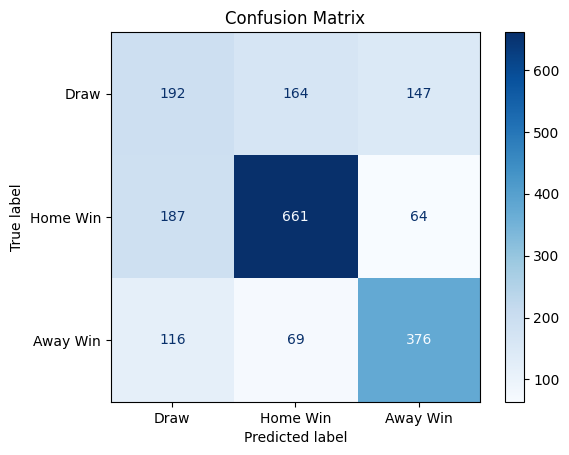


Classification Report:

              precision    recall  f1-score   support

        Draw     0.3879    0.3817    0.3848       503
    Home Win     0.7394    0.7248    0.7320       912
    Away Win     0.6405    0.6702    0.6551       561

    accuracy                         0.6220      1976
   macro avg     0.5893    0.5922    0.5906      1976
weighted avg     0.6218    0.6220    0.6218      1976



In [25]:
# Confusion matrix
class_names = ['Draw', 'Home Win', 'Away Win']
cm = confusion_matrix(y_test, predictions, labels=np.arange(len(class_names)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, predictions, target_names=class_names, digits=4))

### Feature Importance

Another useful insight on our data is feature importance. Each number corresponds to the strength of each feature.

In [26]:
features = ['SeasonID', 'Rank_Home', 'Rank_Away', 'HTHG', 'HTAG',
            'GF_avg_home', 'GA_avg_home', 'GF_avg_away', 'GA_avg_away',
            'Points_avg_home', 'Points_avg_away']

importances = rf.feature_importances_

feat_imp_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_imp_df)

            Feature  Importance
3              HTHG    0.194516
4              HTAG    0.173354
1         Rank_Home    0.105305
2         Rank_Away    0.103488
0          SeasonID    0.079439
10  Points_avg_away    0.061137
7       GF_avg_away    0.058290
9   Points_avg_home    0.057477
5       GF_avg_home    0.056610
6       GA_avg_home    0.055336
8       GA_avg_away    0.055048


As we can see, the Half Time score is the biggest indicator, while the rest share an equal role in the final prediction.

***

## Extreme Gradient Boost - XGB

Another popular algorithm used for predictions, is XGB.

First, we define the classifier.

In [50]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',   # for multi-class classification
    num_class=3,                 # 3 classes
    n_estimators=9000,
    max_depth=9,
    learning_rate=0.001,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss'
)

As mentioned earlier, the class weights need to be calculated to maintain the balance in our dataset.

In [41]:
# Compute weights for each sample
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

We then fit the model

In [51]:
xgb_model.fit(X_train, y_train, sample_weight=sample_weights,
              eval_set=[(X_test, y_test)],
              verbose=False)

,objective,'multi:softmax'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


Next we check the predictions as done before.

Accuracy: 0.6128542510121457


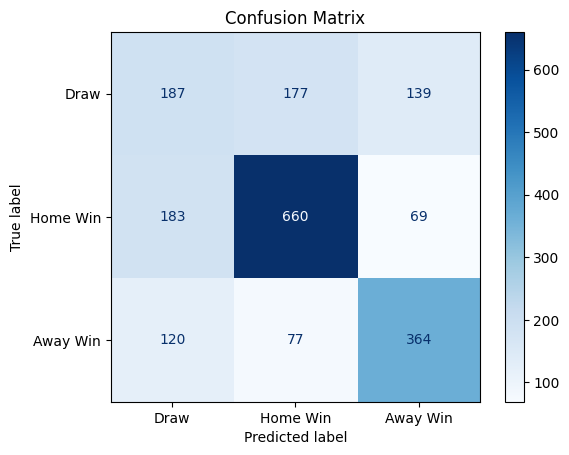

              precision    recall  f1-score   support

        Draw     0.3816    0.3718    0.3766       503
    Home Win     0.7221    0.7237    0.7229       912
    Away Win     0.6364    0.6488    0.6425       561

    accuracy                         0.6129      1976
   macro avg     0.5800    0.5814    0.5807      1976
weighted avg     0.6111    0.6129    0.6119      1976



In [52]:
y_pred = xgb_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion matrix
class_names = ['Draw', 'Home Win', 'Away Win']
cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(class_names)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.show()


print(classification_report(y_test, y_pred, target_names=class_names, digits= 4))

### Feature Importance

Let's also calculate the feature importance of the XGB Classifier

In [55]:
importances = xgb_model.feature_importances_

feat_imp_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_imp_df)

            Feature  Importance
3              HTHG    0.339214
4              HTAG    0.321424
2         Rank_Away    0.042834
1         Rank_Home    0.042074
10  Points_avg_away    0.037698
9   Points_avg_home    0.037082
0          SeasonID    0.036986
5       GF_avg_home    0.035993
7       GF_avg_away    0.035732
8       GA_avg_away    0.035602
6       GA_avg_home    0.035361


***

## Multi-Layer Perceptron

Last but not least we will evaluate the performance of a Multi-Layer Perceptron.

As opposed to the previous two models, a MLP is fully manual, meaning it requires you to implement all the working functions.

### Functions

Let's start with the train and test step. Each batch will be passed through the model, the loss will be calculated and in the training part the weights will be updated.

In [32]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = 'cpu'):
    model.train()
    model.to(device)

    train_loss = 0.0
    correct = 0
    total = 0

    for batch, y_batch in data_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        y_batch = y_batch.to(device)

        y_pred = model(batch)

        # Loss
        loss = loss_fn(y_pred, y_batch)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Stats
        train_loss += loss.item()
        preds = y_pred.argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    avg_loss = train_loss / len(data_loader)
    accuracy = correct / total

    return avg_loss, accuracy

In [33]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = 'cpu'):
    model.eval()
    model.to(device)

    test_loss = 0.0
    correct = 0
    total = 0

    with torch.inference_mode():
        for batch, y_batch in data_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            y_batch = y_batch.to(device)

            y_pred = model(batch)
            loss = loss_fn(y_pred, y_batch)
            test_loss += loss.item()

            preds = y_pred.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

    avg_loss = test_loss / len(data_loader)
    accuracy = correct / total

    return avg_loss, accuracy

Next we implement an Early Stopping class, which helps prevent overfitting by stopping training when no progress has been made for a fixed amount of epochs. Also, in case of early stopping it will restore the best performing model.

In [34]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0, verbose=False, path='best_model.pth', monitor="loss"):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.path = path
        self.monitor = monitor  # "loss" or "accuracy"

        if monitor == "loss":
            self.best_score = float("inf")
        elif monitor == "accuracy":
            self.best_score = float("-inf")
        else:
            raise ValueError("monitor must be 'loss' or 'accuracy'")

        self.counter = 0
        self.early_stop = False
        self.best_epoch = -1

    def __call__(self, val_score, model, epoch=None):
        if self.monitor == "loss":
            improvement = val_score < self.best_score - self.min_delta
        else:  # accuracy
            improvement = val_score > self.best_score + self.min_delta

        if improvement:
            self.best_score = val_score
            self.counter = 0
            self.best_epoch = epoch
            torch.save(model.state_dict(), self.path)
            if self.verbose:
                print(f"Validation {self.monitor} improved to {val_score:.6f}. Saving model...")
        else:
            self.counter += 1
            if self.verbose:
                print(f"No improvement. Counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

        return self.early_stop

    def get_best_score(self):
        return self.best_score

We then plug all the above functions in a training loop.

In [35]:
def train_test_model(num_epochs: int, 
                     model: torch.nn.Module,
                     train_loader: torch.utils.data.DataLoader,
                     test_loader: torch.utils.data.DataLoader,
                     loss_fn: torch.nn.Module,
                     optimizer: torch.optim.Optimizer,
                     scheduler=None,
                     early_stopper=None,
                     device: torch.device = 'cpu',
                     do_test: bool = True,
                     verbose: bool = True):

    train_loss_arr, test_loss_arr = [], []
    train_acc_arr, test_acc_arr = [], []

    for epoch_idx in range(num_epochs):
        # ---- Train ----
        train_loss, train_acc = train_step(model, train_loader, loss_fn, optimizer, device)
        train_loss_arr.append(train_loss)
        train_acc_arr.append(train_acc)


        # ---- Evaluate ----
        if do_test:
            test_loss, test_acc = test_step(model, test_loader, loss_fn, device)
            test_loss_arr.append(test_loss)
            test_acc_arr.append(test_acc)

            # Scheduler update (if any)
            if scheduler is not None:
                scheduler.step(test_loss)
                after_lr = optimizer.param_groups[0]['lr']
            else:
                after_lr = None
            # Print progress
            if verbose and (epoch_idx % 10 == 0 or epoch_idx == num_epochs - 1):
                print(f"Epoch {epoch_idx:03d} | "
                      f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
                      f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f} | "
                      f"lr = {after_lr}")

            # Early stopping
            if early_stopper is not None:
                if early_stopper(test_acc, model, epoch=epoch_idx):
                    if verbose:
                        print(f"Early stopping triggered at epoch {epoch_idx}")
                    break
        else:
            # Print progress (train only)
            if verbose and (epoch_idx % 10 == 0 or epoch_idx == num_epochs - 1):
                print(f"Epoch {epoch_idx:03d} | "
                      f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
                      f"lr = {after_lr}")

    # ---- Load best model if early stopping was used ----
    if early_stopper is not None and early_stopper.path is not None:
        model.load_state_dict(torch.load(early_stopper.path))
        if verbose:
            print(f"Loaded best model from {early_stopper.path}")

    if do_test:
        class_names = ['Draw', 'Home Win', 'Away Win']  # ordered by encoding 0,1,2
        evaluate_confusion_matrix(model, test_loader, device=device, class_names=class_names)
        return train_loss_arr, test_loss_arr, train_acc_arr, test_acc_arr, early_stopper.get_best_score() if early_stopper else None
    else:
        return train_loss_arr, train_acc_arr

And finally a function to plot the final training curve.

In [36]:
def plot_results(train_arr, test_arr=None, normalize=False, title="Training Progress"):
    train_arr = np.array(train_arr)
    if test_arr is not None:
        test_arr = np.array(test_arr)

    if normalize:
        min_val = np.min(train_arr if test_arr is None else np.concatenate([train_arr, test_arr]))
        max_val = np.max(train_arr if test_arr is None else np.concatenate([train_arr, test_arr]))
        train_arr = (train_arr - min_val) / (max_val - min_val)
        if test_arr is not None:
            test_arr = (test_arr - min_val) / (max_val - min_val)

    plt.figure(figsize=(8, 5))
    plt.plot(train_arr, label='Train Loss', linewidth=2)
    if test_arr is not None:
        plt.plot(test_arr, label='Test Loss', linewidth=2)
    plt.xlabel("Epochs")
    plt.ylabel("Loss (normalized)" if normalize else "Loss")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

### MLP implementation

The Neural Network will include three embeddings to represent the Season, Home Rank and Away Rank. The rest of the variables are numeric so no need to embed them.

Furthermore, it will include three Linear layers with shrinking dimensions. Between the first two layers we apply BatchNormalization and Dropout to help prevent overfitting and improve regularisation. The activation function is ReLU. 

In [37]:
class MatchOutcomeNN(nn.Module):
    def __init__(self, 
                 num_seasons: int,
                 num_teams: int,
                 emb_dim: int = 8,
                 hidden_dim: int = 64,
                 num_classes: int = 3):
        super().__init__()
        
        # Embeddings
        self.season_emb = nn.Embedding(num_seasons, emb_dim)
        self.home_emb   = nn.Embedding(num_teams + 1, emb_dim)  # +1 if ranks start at 1
        self.away_emb   = nn.Embedding(num_teams + 1, emb_dim)
        
        # Input size = season_emb + home_emb + away_emb + 8 numeric features
        in_dim = emb_dim * 3 + 8
        
        # MLP
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim//2)
        self.bn2 = nn.BatchNorm1d(hidden_dim//2)
        self.fc3 = nn.Linear(hidden_dim // 2, num_classes)

    def forward(self, batch):
        season_vec = self.season_emb(batch["season_id"])
        home_vec   = self.home_emb(batch["home_rank"])
        away_vec   = self.away_emb(batch["away_rank"])

        goals = torch.stack([
            batch["home_goals"], batch["away_goals"],
            batch["gf_avg_home"], batch["ga_avg_home"],
            batch["gf_avg_away"], batch["ga_avg_away"],
            batch["points_avg_home"], batch["points_avg_away"]
        ], dim=1)

        x = torch.cat([season_vec, home_vec, away_vec, goals], dim=1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.dropout(x, p=0.2, training=self.training)
        return self.fc3(x)


Next we implement a class to match the datasets to their correct data type.

In [38]:
class MatchDataset(Dataset):
    def __init__(self, info_tensor, label_tensor):
        # Split categorical + numeric
        self.season_id   = info_tensor[:, 0].long()
        self.home_rank   = info_tensor[:, 1].long()
        self.away_rank   = info_tensor[:, 2].long()
        self.home_goals  = info_tensor[:, 3].float()
        self.away_goals  = info_tensor[:, 4].float()
        self.gf_avg_home = info_tensor[:, 5].float()
        self.ga_avg_home = info_tensor[:, 6].float()
        self.gf_avg_away = info_tensor[:, 7].float()
        self.ga_avg_away = info_tensor[:, 8].float()
        self.points_avg_home = info_tensor[:, 9].float()
        self.points_avg_away = info_tensor[:, 10].float()

        self.y = label_tensor.long()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return {
            "season_id": self.season_id[idx],
            "home_rank": self.home_rank[idx],
            "away_rank": self.away_rank[idx],
            "home_goals": self.home_goals[idx],
            "away_goals": self.away_goals[idx],
            "gf_avg_home": self.gf_avg_home[idx],
            "ga_avg_home": self.ga_avg_home[idx],
            "gf_avg_away": self.gf_avg_away[idx],
            "ga_avg_away": self.ga_avg_away[idx],
            "points_avg_home": self.points_avg_home[idx],
            "points_avg_away": self.points_avg_away[idx],
        }, self.y[idx]

Now we will create the Datasets and instantiate the model.

In [39]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    info_tensor_fe, label_tensor_fe, 
    test_size=0.2, 
    random_state=42, 
    stratify=label_tensor_fe
)

In [40]:
# Datasets
train_dataset = MatchDataset(X_train, y_train)
test_dataset = MatchDataset(X_test, y_test)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [41]:
# Detect max IDs
num_seasons = int(info_tensor_fe[:, 0].max().item()) + 1
num_teams   = int(torch.cat([info_tensor_fe[:, 1], info_tensor_fe[:, 2]]).max().item()) + 1

print(f"Detected {num_seasons} seasons and {num_teams} teams")

Detected 27 seasons and 48 teams


In [42]:
# Instantiate embedding model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MatchOutcomeNN(
    num_seasons=num_seasons,
    num_teams=num_teams,
    emb_dim=2,         # can tune this
    hidden_dim=32,     # can tune this
    num_classes=3
).to(device)

For the loss function, it makes sense to use th CrossEntropyLoss with the calculated class weights.

In [43]:
class_counts = torch.bincount(y_train.long())
class_weights = len(y_train) / (len(class_counts) * class_counts.float())

loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))

The optimizer used is AdamW with an initial learning rate of $10^{-3}$, the scheduler is the ReduceLROnPlateau which helps with better convergence by reducing the learning rate when the loss stagnates. Finally, we also initialize our Early Stopping method which will stop training if no progress has been made in the last 30 epochs.

In [44]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay= 1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=10, min_lr=1e-5
)
early_stopper = EarlyStopping(patience=30, verbose=False, monitor="accuracy")

Now, let's train the model and check the results.

Epoch 000 | Train Loss: 1.0337 | Train Acc: 0.4527 | Test Loss: 0.9095 | Test Acc: 0.5916 | lr = 0.001
Epoch 010 | Train Loss: 0.8772 | Train Acc: 0.5973 | Test Loss: 0.8631 | Test Acc: 0.6164 | lr = 0.001
Epoch 020 | Train Loss: 0.8666 | Train Acc: 0.6050 | Test Loss: 0.8569 | Test Acc: 0.6088 | lr = 0.001
Epoch 030 | Train Loss: 0.8569 | Train Acc: 0.6070 | Test Loss: 0.8574 | Test Acc: 0.6204 | lr = 0.001
Epoch 040 | Train Loss: 0.8548 | Train Acc: 0.6185 | Test Loss: 0.8549 | Test Acc: 0.6164 | lr = 0.001
Epoch 050 | Train Loss: 0.8504 | Train Acc: 0.6125 | Test Loss: 0.8557 | Test Acc: 0.6149 | lr = 0.001
Epoch 060 | Train Loss: 0.8414 | Train Acc: 0.6225 | Test Loss: 0.8560 | Test Acc: 0.6184 | lr = 0.0001
Epoch 070 | Train Loss: 0.8408 | Train Acc: 0.6172 | Test Loss: 0.8561 | Test Acc: 0.6204 | lr = 1e-05
Epoch 080 | Train Loss: 0.8433 | Train Acc: 0.6132 | Test Loss: 0.8561 | Test Acc: 0.6235 | lr = 1e-05
Epoch 090 | Train Loss: 0.8387 | Train Acc: 0.6221 | Test Loss: 0.8569 |

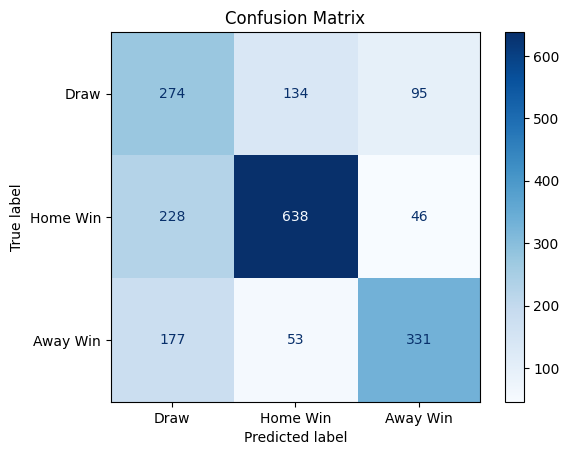


Classification Report:

              precision    recall  f1-score   support

        Draw     0.4035    0.5447    0.4636       503
    Home Win     0.7733    0.6996    0.7346       912
    Away Win     0.7013    0.5900    0.6409       561

    accuracy                         0.6290      1976
   macro avg     0.6260    0.6114    0.6130      1976
weighted avg     0.6587    0.6290    0.6390      1976



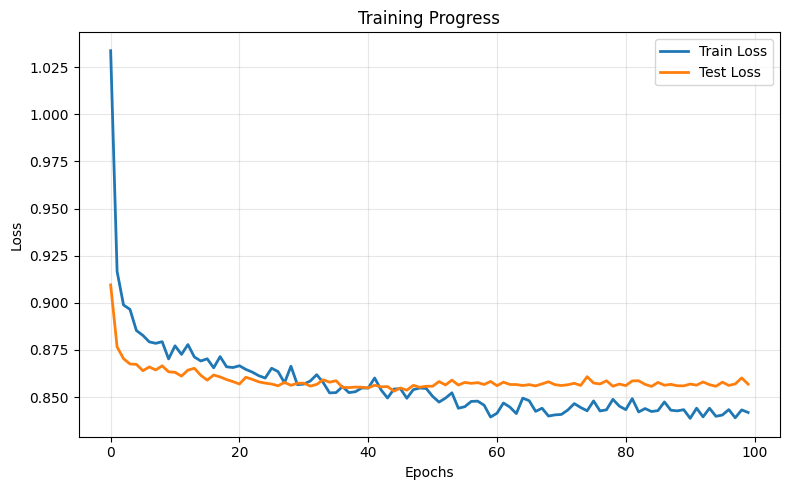

In [ ]:
train_loss, test_loss, train_acc, test_acc, best_loss = train_test_model(
    num_epochs=100,
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    scheduler=scheduler,
    early_stopper=early_stopper,
    device=device
)

plot_results(train_loss, test_loss)

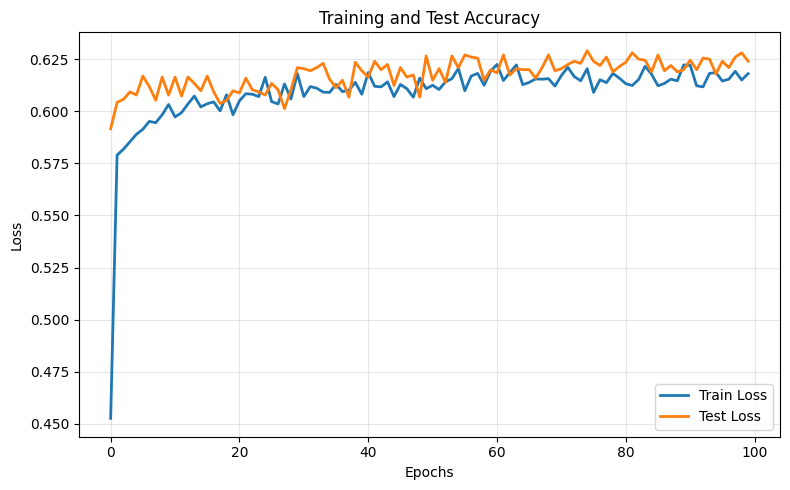

In [ ]:
plot_results(train_acc, test_acc, title="Training and Test Accuracy")

***